# Cluster Interaction Analysis

**Author**: Alma Andersson<br>
**Description**:<br>
<br>
Workflow to assess patterns of interaction between different clusters.
For every spot within each cluster we register the identity of the 4 nearest neighbors (NN) (with a distance less than a threshold to said spot). By doing so we can then compute - for each cluster - the fraction of NNs that belong to each respective cluster. By permuting the cluster labels, a null distribution can be generated to put the observed values into context.
<hr>

In [106]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import packages and set global variables

`K` is the number of NNs to use and `EPS_FACTOR` is used to compute the distance threshold, the larger the value the large the allowed distance will be. For 2K arrays,`1.3` has provided good results.

In [107]:
import pandas as pd
import numpy as np 
from scipy.spatial import KDTree
from scipy import stats
import matplotlib.pyplot as plt
import glob
import os.path as osp
from typing import *
import seaborn as sns

In [108]:
K = 4
EPS_FACTOR = 1.3 

### Data-related variables

In [109]:
# directory to load data from
DATA_DIR = "../data/clusters/new_ids/"
# directory to save results to
RES_DIR = "../res/cluster/nbrs/"
# make results directory if not already exists
#if not osp.exists(RES_DIR):
 #   from os import mkdir
  #  mkdir(RES_DIR)
    
# get paths for data files
pths = glob.glob(osp.join(DATA_DIR,
                          "*tsv"))

## Load data

In [110]:
# load data from list of paths
data = list()
for pth in pths:
    _tmp = pd.read_csv(pth,
                       sep = "\t",
                       header = 0,
                       index_col = 0,
                      )
    data.append(_tmp)

In [111]:
data[1]

,x_cord,y_cord,cluster
10x32,10,32,1
10x34,10,34,5
10x36,10,36,5
11x29,11,29,5
11x31,11,31,1
...,...,...,...
60x38,60,38,5
61x33,61,33,6
61x35,61,35,5
61x37,61,37,5


In [112]:
def generate_stats(data : List[pd.DataFrame],
                   cluster_label : str = "cluster",
                   )->Dict[str,pd.DataFrame]:
    
    """Generate NN stats
    
    Parameters:
    ----------
    
    data : List[pd.DataFrame]
        list of pandas data frame holding cluster
        data. Assumes cluster labels are same across
        whole data set.
    cluster_label : str (cluster)
        name of column holding cluster
        information
    
    Returns:
    -------
    Dictionary with stats for each cluster
    
    """

    all_sample_stats = dict()
    all_labels = list()

    for _tmp in data:

        _drop = np.isnan(_tmp[cluster_label].values)
        _tmp = _tmp.iloc[~_drop,:]

        _crd = _tmp[["x_cord","y_cord"]].values.astype(float)
        _crd /= _crd.max()
        _kd = KDTree(_crd)

        ds,idxs = _kd.query(_crd, k =  2)
        upper_bound = ds[:,1::].mean() * EPS_FACTOR  * 0.9

        ds,idxs = _kd.query(_crd,
                            k = K +1,
                            distance_upper_bound = upper_bound)
        ds = ds[:,1::]
        idxs = idxs[:,1::]

        uni_labels = np.unique(_tmp[cluster_label].values.astype(float))
        np.sort(uni_labels)

        all_labels += uni_labels.tolist()

        n_labels = uni_labels.shape[0]

        tmp_labels = np.append(_tmp[cluster_label].values.astype(float),"none")

        for label in uni_labels:
            if label not in all_sample_stats.keys():
                all_sample_stats[label] = list()

            pos = np.where(_tmp[cluster_label].values == label)[0]

            nn_stats = np.zeros((pos.shape[0],
                                 n_labels + 1,
                                ))
            
            nn_stats = pd.DataFrame(nn_stats,
                                    columns = pd.Index(np.append(uni_labels,"none")\
                                                       .astype(str)),
                               )

            for k,p in enumerate(pos):
                nbr_labels = tmp_labels[idxs[p,:]]
                val,cnt = np.unique(nbr_labels,return_counts = True)
                nn_stats.loc[k,val.astype(str)] = cnt

            all_sample_stats[label].append(nn_stats.iloc[:,nn_stats.columns != "none"])

    for k,v in all_sample_stats.items():
        all_sample_stats[k] = pd.concat(v)
        
    return all_sample_stats

## Analysis

Compute NN stats for respective cluster across the whole data set and add reference from null distribution if specified.

In [113]:
# set to true to add null distribution
# can take some time
include_reference = True
# name of column holding cluster information
cluster_label = "cluster"

# get stats for complete data set
all_sample_stats = generate_stats(data,
                                 cluster_label = cluster_label,
                                 )

# generate and compute null distribution
if include_reference:
    n_iter = 10
    from copy import deepcopy
    perm_stats = dict()

    for k,d in all_sample_stats.items():
        perm_stats[k] = np.zeros((n_iter,d.shape[1]))


    for ii in range(n_iter):
        print("\rIteration {:2.0f}/{}".format(ii+1,n_iter),end="")
        tmp_data = list()
        for d in data:
            perm_cidx = np.random.permutation(d.shape[0])
            _tmp = deepcopy(d)
            _tmp[cluster_label] = _tmp[cluster_label].values[perm_cidx]
            tmp_data.append(_tmp)
            
        tmp_stats = generate_stats(tmp_data,
                                  cluster_label = cluster_label,
                                  )
        for k,v in tmp_stats.items():
            perm_stats[k][ii,:] = v.values.sum(axis=0)
            perm_stats[k][ii,:] /= perm_stats[k][ii,:].sum()

    for k,v in perm_stats.items():
        perm_stats[k] = dict(mean = perm_stats[k].mean(axis = 0),
                             std = perm_stats[k].std(axis= 0)
                            )

Iteration 10/10

In [114]:
section_id = 1
for d in data:
    d['section'] = section_id
    section_id += 1
alldata = pd.concat(data)
alldata.tail()

,x_cord,y_cord,cluster,section
51x39,51,39,5,38
52x32,52,32,0,38
52x34,52,34,3,38
52x36,52,36,0,38
52x38,52,38,0,38


In [115]:
def generate_random_stats(df, cluster_label: str = "cluster", n_iter: int = 1) -> Dict[str, pd.DataFrame]:
    """Generate random permutation stats for cluster data.

    Parameters:
    ----------
    df : concatenated data of all sections   
    cluster_label : str (default "cluster")
        Name of column holding cluster information.
    n_iter : int (default 10)
        Number of iterations to perform.

    Returns:
    -------
    Dictionary with stats for each cluster, computed after randomly permuting cluster labels.
    """
    random_stats = dict() # list of dictionaries containing the stats for each round of permutation
    all_labels = list()
    
    #alldata = pd.concat[data]
    
    for i in range(n_iter):
        print("\rIteration {}/{}".format(i+1, n_iter), end="")
        #perm_data = list()

        perm_cidx = np.random.permutation(df.shape[0])
        _tmp = df.copy()
        _tmp[cluster_label] = _tmp[cluster_label].values[perm_cidx]
        #perm_data.append(_tmp)
        perm_data = _tmp
        perm_data_sectionlist = []
        for section in perm_data['section'].unique():
            perm_data_sectionlist.append(perm_data[perm_data['section']==section])
        #print("The length of perm data: ", len(perm_data_sectionlist))
        perm_sample_stats = generate_stats(perm_data_sectionlist, cluster_label)
        
        for label, stats in perm_sample_stats.items():
            if label not in random_stats.keys():
                random_stats[label] = list()
            random_stats[label].append(stats)
        #random_stats.append(stats_dict)
        #print("In iteration for loop: ", len(random_stats))
    #print(random_stats.items())
    for label, stats_list in random_stats.items():
        random_stats[label] = pd.concat(stats_list)
    print("Final: ", len(random_stats))
    return random_stats

random_perm_stats = generate_random_stats(alldata)

Iteration 1/1Final:  12


In [116]:
random_perm_stats

{0.0:      0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0  10.0  11.0
 0    1.0  0.0  0.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0
 1    0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   1.0   0.0
 2    1.0  1.0  0.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0
 3    0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0
 4    1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0
 ..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...
 136  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0   0.0   NaN
 137  1.0  1.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0   0.0   NaN
 138  2.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   NaN
 139  2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   NaN
 140  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   NaN
 
 [6372 rows x 12 columns],
 1.0:      0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0  10.0  11.0
 0    0.0  0.0  0.0  0.0  0.0  0.0  2.0  0.0  0.0  0.0   0.0   0.0
 1    1.0  1.0  0.0  1.

In [124]:
nn_count_df = pd.DataFrame(columns = ['Cluster', 'Neighbour', 'nn_count'])
allclusterids = [0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0]
countlist =[]
clusterlist = []
neighbourlist = []
for cl in allclusterids:
    cl_df = all_sample_stats.get(cl)
    for neighbour in allclusterids:
        count = cl_df[str(neighbour)].sum()
        countlist.append(count)
        clusterlist.append(cl)
        neighbourlist.append(neighbour)
print(len(countlist), len(clusterlist), len(neighbourlist))
nn_count_df = pd.DataFrame(list(zip(clusterlist, neighbourlist, countlist)),
               columns =['Cluster', 'Neighbour', 'nn_count'])

#nn_count_df = pd.DataFrame([clusterlist, neighbourlist, countlist],columns =['Cluster', 'Neighbour', 'count'])
nn_count_df

144 144 144


,Cluster,Neighbour,nn_count
0,0.0,0.0,9082.0
1,0.0,1.0,4267.0
2,0.0,2.0,3366.0
3,0.0,3.0,1088.0
4,0.0,4.0,1947.0
...,...,...,...
139,11.0,7.0,8.0
140,11.0,8.0,6.0
141,11.0,9.0,2.0
142,11.0,10.0,5.0


In [125]:
all_sample_stats

{0.0:      0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0  10.0  11.0
 0    0.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0   0.0   0.0
 1    1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0
 2    1.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   0.0   0.0
 3    2.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   0.0   0.0
 4    1.0  0.0  2.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   0.0   0.0
 ..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...
 190  2.0  0.0  0.0  0.0  2.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0
 191  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0   0.0   0.0
 192  0.0  0.0  0.0  0.0  2.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0
 193  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   0.0   0.0
 194  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0   0.0   0.0
 
 [6372 rows x 12 columns],
 1.0:      0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0  10.0  11.0
 0    0.0  0.0  1.0  0.0  1.0  1.0  0.0  1.0  0.0  0.0   0.0   0.0
 1    0.0  2.0  0.0  1.

In [126]:
#Do the same for the randomly permuted data 

nn_perm_df = pd.DataFrame(columns = ['Cluster', 'Neighbour', 'nn_count'])
allclusterids = [0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0]
countlist =[]
clusterlist = []
neighbourlist = []
for cl in allclusterids:
    cl_df = random_perm_stats.get(cl)
    for neighbour in allclusterids:
        count = cl_df[str(neighbour)].sum()
        countlist.append(count)
        clusterlist.append(cl)
        neighbourlist.append(neighbour)
print(len(countlist), len(clusterlist), len(neighbourlist))
nn_perm_df = pd.DataFrame(list(zip(clusterlist, neighbourlist, countlist)),
               columns =['Cluster', 'Neighbour', 'nn_count'])

#nn_count_df = pd.DataFrame([clusterlist, neighbourlist, countlist],columns =['Cluster', 'Neighbour', 'count'])
nn_perm_df

144 144 144


,Cluster,Neighbour,nn_count
0,0.0,0.0,6072.0
1,0.0,1.0,5275.0
2,0.0,2.0,4030.0
3,0.0,3.0,2550.0
4,0.0,4.0,1681.0
...,...,...,...
139,11.0,7.0,9.0
140,11.0,8.0,9.0
141,11.0,9.0,7.0
142,11.0,10.0,2.0


In [127]:
### binomial test to calculate the overrepresentation of clustr in certain neighbourhoods
def cl_overrep(nn_df):
    
    
    
    
    cl_overrep_df = pd.DataFrame(columns = ['Cluster', 'Neighbour', 'nn_count', 'fraction', 'interaction',
                                           'pval_under', 'pval_over', 'fraction_bg'])
    bg_total_neighbours = nn_df['nn_count'].sum()
    for cl in nn_df['Cluster'].unique():
        print('Now processing cluster: ', cl)
        cl_df = nn_df[nn_df['Cluster']==cl]
        total_neighbours = cl_df['nn_count'].sum()
        for i in cl_df.index:
            neighbour = cl_df.Neighbour[i]
            count = cl_df.nn_count[i]
            fraction = count/total_neighbours
            bg_fraction = nn_df[nn_df['Neighbour'] == neighbour]['nn_count'].sum()/bg_total_neighbours
            print(cl, count, fraction, bg_fraction)
            ### binomial test
            pval_under = stats.binom_test(count, n=total_neighbours, p=bg_fraction, alternative='less')
            pval_over = stats.binom_test(count, n=total_neighbours, p=bg_fraction, alternative='greater')
            ratio = fraction/bg_fraction
            if ratio <= 1:
                if fraction != 0:
                    ratio = bg_fraction/fraction*(-1)
                else:
                    ratio = 0
                print(ratio)
            cl_overrep_df.loc[len(cl_overrep_df)] = [cl,neighbour,count,fraction,ratio,pval_under, pval_over, bg_fraction]
            
            #cl_overrep_df = cl_overrep_df.append({'Cluster':cl, 'Neighbour':neighbour, 'nn_count':count, 'fraction':fraction,
            #                                      'interaction':ratio,'pval_under':pval_under, 'pval_over':pval_over, 
            #                                      'fraction_bg':bg_fraction}, ignore_index = True)
    return cl_overrep_df

overrep_df = cl_overrep(nn_count_df)
overrep_df
overrep_perm = cl_overrep(nn_perm_df)
overrep_perm

Now processing cluster:  0.0
0.0 9082.0 0.3712393721386527 0.25541333444697334
0.0 4267.0 0.174419555264879 0.21911215050844626
-1.2562361495286218
0.0 3366.0 0.13758992805755396 0.1710342235493099
-1.2430722652734156
0.0 1088.0 0.04447351209941138 0.11017727756781023
-2.4773684911938507
0.0 1947.0 0.0795863309352518 0.0682069699943622
0.0 975.0 0.03985448005232178 0.043003904700256834
-1.0790231021405983
0.0 1863.0 0.07615271419228253 0.05232715959157253
0.0 986.0 0.040304120340091565 0.034275751184982564
0.0 263.0 0.010750490516677567 0.017404105155457185
-1.6189126559813862
0.0 238.0 0.009728580771746239 0.014491240525359671
-1.4895533958504161
0.0 325.0 0.01328482668410726 0.012277881021486291
0.0 64.0 0.002616088947024199 0.002276001753983003
Now processing cluster:  1.0
1.0 4267.0 0.20331633868585314 0.25541333444697334
-1.2562361495286218
1.0 6618.0 0.3153380664220708 0.21911215050844626
1.0 2089.0 0.09953780911993139 0.1710342235493099
-1.718283987376432
1.0 3577.0 0.1704388430

-1.0983355824796093
6.0 172.0 0.03527481542247744 0.03391033805934309
6.0 86.0 0.01763740771123872 0.0203169697855547
-1.1519249380740082
6.0 70.0 0.01435602953240361 0.014720928775761625
-1.0254178387230526
6.0 47.0 0.009639048400328138 0.011891587145810277
-1.2336889132547002
6.0 19.0 0.003896636587366694 0.002307322879037815
Now processing cluster:  7.0
7.0 804.0 0.24753694581280788 0.25107013843937276
-1.0142733950884113
7.0 708.0 0.21798029556650247 0.21871541625775198
-1.00337241808641
7.0 545.0 0.16779556650246305 0.169572571046752
-1.0105902949722028
7.0 363.0 0.11176108374384236 0.10658578856152513
7.0 224.0 0.06896551724137931 0.06844709861978242
7.0 163.0 0.05018472906403941 0.0515545718402205
-1.0272960082026759
7.0 172.0 0.05295566502463054 0.05090726858908772
7.0 112.0 0.034482758620689655 0.03391033805934309
7.0 50.0 0.01539408866995074 0.0203169697855547
-1.3197903572696332
7.0 35.0 0.010775862068965518 0.014720928775761625
-1.3661021903906787
7.0 63.0 0.019396551724137

,Cluster,Neighbour,nn_count,fraction,interaction,pval_under,pval_over,fraction_bg
0,0.0,0.0,6072.0,0.252495,1.005675,0.697736,0.307465,0.251070
1,0.0,1.0,5275.0,0.219353,1.002915,0.598065,0.407977,0.218715
2,0.0,2.0,4030.0,0.167582,-1.011881,0.207944,0.796961,0.169573
3,0.0,3.0,2550.0,0.106038,-1.005167,0.396537,0.611507,0.106586
4,0.0,4.0,1681.0,0.069902,1.021254,0.817756,0.189030,0.068447
...,...,...,...,...,...,...,...,...
139,11.0,7.0,9.0,0.040724,1.200931,0.780075,0.336012,0.033910
140,11.0,8.0,9.0,0.040724,2.004432,0.984182,0.038152,0.020317
141,11.0,9.0,7.0,0.031674,2.151645,0.982455,0.046643,0.014721
142,11.0,10.0,2.0,0.009050,-1.314020,0.510476,0.739830,0.011892


/var/folders/5h/3ztn3hns2rbfbq32pqrfrd1w0000gn/T/ipykernel_61270/4028587631.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  overrep_df2 = overrep_df.pivot('Cluster', 'Neighbour', 'interaction')


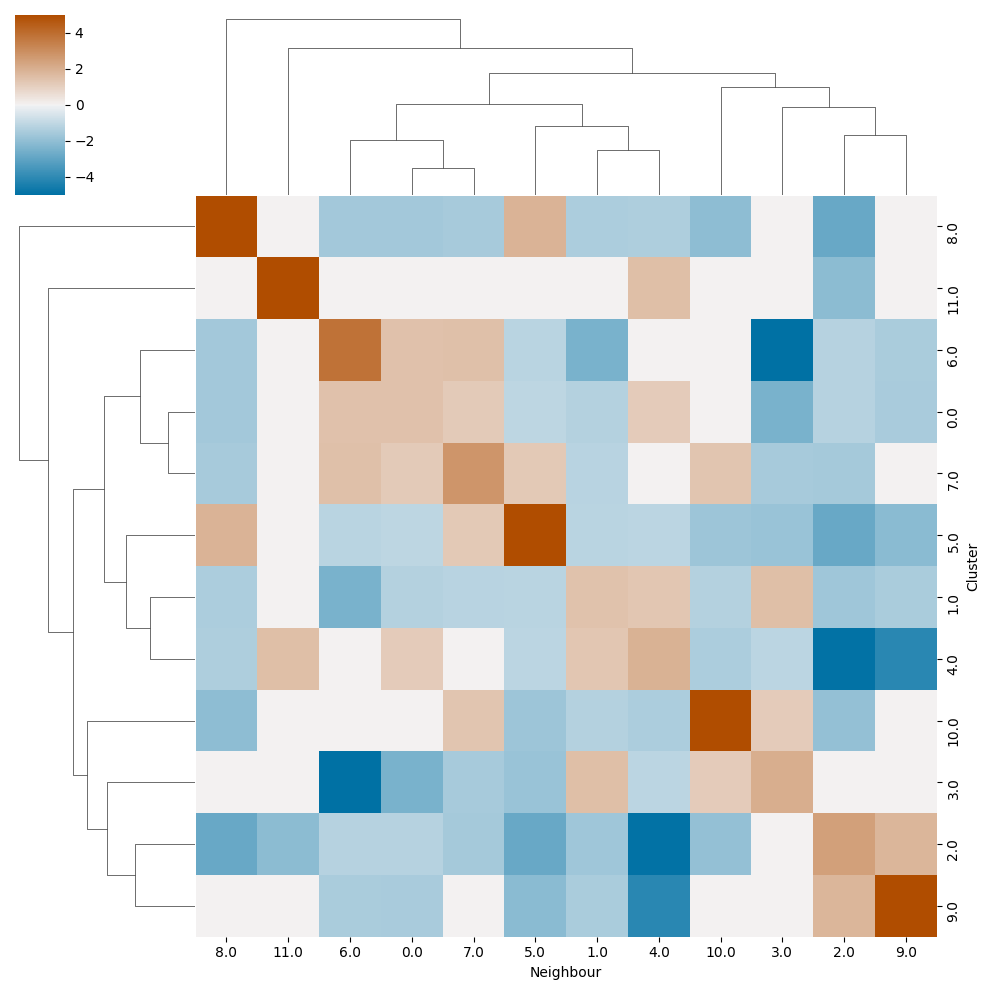

In [128]:
### let's plot
color_map = sns.diverging_palette(240,26, s = 100, l =45,as_cmap= True)
for i in overrep_df.index:
    if overrep_df.pval_under[i] >= 0.05 and overrep_df.pval_over[i] >= 0.05:
        overrep_df.interaction[i] = 0
    #if overrep_df.interaction[i] <= 1.5 and overrep_df.interaction[i] >= -1.5:
     #   overrep_df.interaction[i] = 0
overrep_df2 = overrep_df.pivot('Cluster', 'Neighbour', 'interaction')
#ax = sns.heatmap(overrep_df2, cmap= color_map, vmin= -4, vmax= 4)

sns.clustermap(overrep_df2, cmap = color_map, vmin = -5, vmax=5, metric = 'euclidean', method = 'complete')
plt.savefig('/Users/franziskahildebrandt/P.Berghei-Liver/res/figures/figure2/neighbour_fractions_adjusted_colors_true.pdf', bbox_inches='tight')

/var/folders/5h/3ztn3hns2rbfbq32pqrfrd1w0000gn/T/ipykernel_61270/4113588287.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  overrep_perm_df2 = overrep_perm.pivot('Cluster', 'Neighbour', 'interaction')


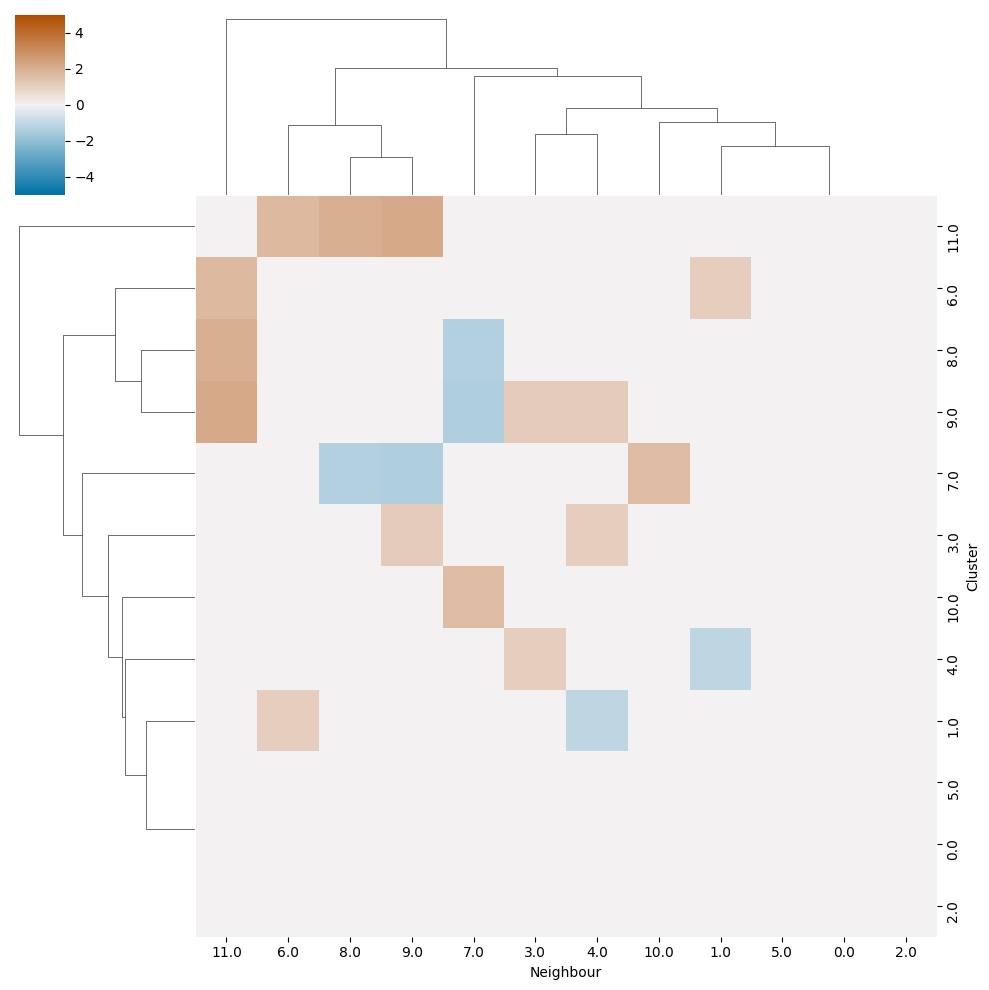

In [129]:
### let's plot
color_map = sns.diverging_palette(240,26, s = 100, l =45,as_cmap= True)
for i in overrep_perm.index:
    if overrep_perm.pval_under[i] >= 0.05 and overrep_perm.pval_over[i] >= 0.05:
        overrep_perm.interaction[i] = 0
    #if overrep_perm.interaction[i] <= 1.5 and overrep_perm.interaction[i] >= -1.5:
        #overrep_perm.interaction[i] = 0
overrep_perm_df2 = overrep_perm.pivot('Cluster', 'Neighbour', 'interaction')

#ax = sns.heatmap(overrep_perm_df2, cmap= color_map, vmin= -4, vmax =4)

sns.clustermap(overrep_perm_df2, cmap = color_map, vmin = -5, vmax=5, metric = 'euclidean', method = 'complete')
plt.savefig('/Users/franziskahildebrandt/P.Berghei-Liver/res/figures/supplementary/random_permutation_enrichment_random.pdf', bbox_inches='tight')